Re-create the network architecture used by rl_games
```
Network(

  (value_mean_std): RunningMeanStd()

  (a2c_network): Network(

    (actor_cnn): Sequential(

      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))

      (1): ReLU()

      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))

      (3): ReLU()

      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))

      (5): ReLU()

    )

    (critic_cnn): Sequential()

    (actor_mlp): Sequential(

      (0): Linear(in_features=36864, out_features=512, bias=True)

      (1): ELU(alpha=1.0)

    )

    (critic_mlp): Sequential()

    (value): Linear(in_features=512, out_features=1, bias=True)

    (value_act): Identity()

    (mu): Linear(in_features=512, out_features=2, bias=True)

    (mu_act): Identity()

    (sigma_act): Identity()

  )

)
```

In [82]:
import torch.nn as nn
import torch
import numpy as np

In [83]:
class RunningMeanStd(nn.Module):
    def __init__(self, insize, epsilon=1e-05, per_channel=False, norm_only=False):
        super(RunningMeanStd, self).__init__()
        print('RunningMeanStd: ', insize)
        self.insize = insize
        self.epsilon = epsilon

        self.norm_only = norm_only
        self.per_channel = per_channel
        if per_channel:
            if len(self.insize) == 3:
                self.axis = [0,2,3]
            if len(self.insize) == 2:
                self.axis = [0,2]
            if len(self.insize) == 1:
                self.axis = [0]
            in_size = self.insize[0]
        else:
            self.axis = [0]
            in_size = insize

        self.register_buffer("running_mean", torch.zeros(in_size, dtype = torch.float64))
        self.register_buffer("running_var", torch.ones(in_size, dtype = torch.float64))
        self.register_buffer("count", torch.ones((), dtype = torch.float64))

    def forward(self, input):
        return

In [84]:
class Network(nn.Module):
    def __init__(self, input_shape, action_space_size):
        super(Network, self).__init__()
        self.a2c_network = A2CNetwork(input_shape, action_space_size)
        self.value_mean_std = RunningMeanStd((1,))

    def forward(self, x):
        return self.a2c_network(x)

class A2CNetwork(nn.Module):
    def __init__(self, input_shape, action_space_size):
        super(A2CNetwork, self).__init__()

        # Actor CNN
        self.actor_cnn = nn.Sequential(
            nn.Conv2d(input_shape[2], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()

        )

        # Critic CNN (Empty in this case)
        self.critic_cnn = nn.Sequential()

        # Calculate the size of the flattened output from the CNN
        conv_out_size = self._get_conv_out(input_shape)

        # Actor MLP
        self.actor_mlp = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ELU(alpha=1.0)
        )

        # Critic MLP (Empty in this case)
        self.critic_mlp = nn.Sequential()

        # Value Head
        self.value = nn.Linear(512, 1)
        self.value_act = nn.Identity()

        # Mu (Mean) Head
        self.mu = nn.Linear(512, action_space_size)
        self.mu_act = nn.Identity()

        # Sigma (Standard Deviation) activation (Identity in this case)
        self.sigma_act = nn.Identity()

        self.sigma = nn.Parameter(torch.zeros(action_space_size, requires_grad=True, dtype=torch.float32), requires_grad=True)

    def _get_conv_out(self, shape):
        o = self.actor_cnn(torch.zeros(1, *shape).permute(0, 3, 1, 2))
        return int(np.prod(o.size()))

    def forward(self, x):
        # Actor CNN
        actor_features_original = self.actor_cnn(x)
        actor_features = actor_features_original.reshape(actor_features_original.size(0), -1)
        actor_out = self.actor_mlp(actor_features)
                # Value head
        value = self.value_act(self.value(actor_out))  # Value from actor features

        # Mu head
        mu = self.mu_act(self.mu(actor_out))  # Mean from actor features


        # Sigma (not used in this case since fixed_sigma is True in the config)
        # ... (You would typically handle sigma here if it were learnable)

        return mu, value, actor_features_original, actor_out  # Return mean and value

Instantiate the network

In [86]:
input_shape = (224, 224, 3)
action_space_size = 2
model = Network(input_shape, action_space_size)

RunningMeanStd:  (1,)


Load learned weights

In [88]:
state_dict = torch.load('jetbot-kong-viz.pth')


C:\Users\irvin\AppData\Local\Temp\ipykernel_8972\2836107525.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('jetbot-kong-viz.pth')


In [6]:
state_dict['model']['a2c_network.sigma']

tensor([-1.6382], device='cuda:0')

In [89]:
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [91]:
model.to(device) 

Network(
  (a2c_network): A2CNetwork(
    (actor_cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
    )
    (critic_cnn): Sequential()
    (actor_mlp): Sequential(
      (0): Linear(in_features=36864, out_features=512, bias=True)
      (1): ELU(alpha=1.0)
    )
    (critic_mlp): Sequential()
    (value): Linear(in_features=512, out_features=1, bias=True)
    (value_act): Identity()
    (mu): Linear(in_features=512, out_features=2, bias=True)
    (mu_act): Identity()
    (sigma_act): Identity()
  )
  (value_mean_std): RunningMeanStd()
)

Load sample image

In [92]:
import matplotlib.pyplot as plt


In [93]:
sample_images = torch.load('sample-images-kong.pth')

C:\Users\irvin\AppData\Local\Temp\ipykernel_8972\1434581983.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_images = torch.load('sample-images-kong.pth')


In [94]:
sample_images.shape

torch.Size([8, 224, 224, 3])

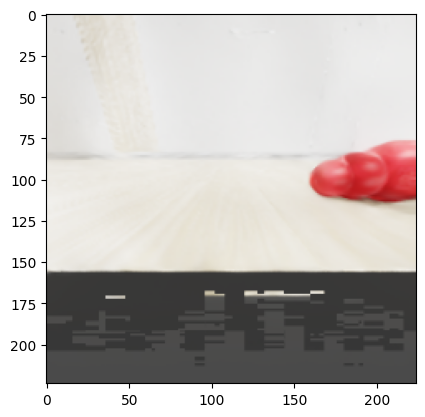

In [95]:
sample_image = sample_images[3]
plt.imshow(sample_image.cpu().numpy())
plt.show()
sample_batch = sample_image.unsqueeze(0).permute(0, 3, 1, 2) / 1.0

Visualization of CNN features

In [96]:
actor_cnn = model.a2c_network.actor_cnn

In [97]:
with torch.no_grad():
    sample_features = actor_cnn(sample_batch)[0]

In [98]:
sample_features.shape

torch.Size([64, 24, 24])

In [99]:
def visualize_features(features, row_count):
    # Normalize the feature maps to [0, 1] for visualization
    normalized_features = (features - features.min()) / (features.max() - features.min())

    col_count = int(len(features)/row_count)
    fig, axes = plt.subplots(row_count, col_count, figsize=(30, 5))  

    feature_index = 0
    for i in range(row_count):
        for j in range(col_count):
            ax = axes[i, j]
            ax.imshow(normalized_features[feature_index].cpu().numpy(), cmap='gray')
            feature_index += 1
            ax.axis('off')
    plt.subplots_adjust(hspace=0)
    plt.tight_layout()
    
    plt.show()

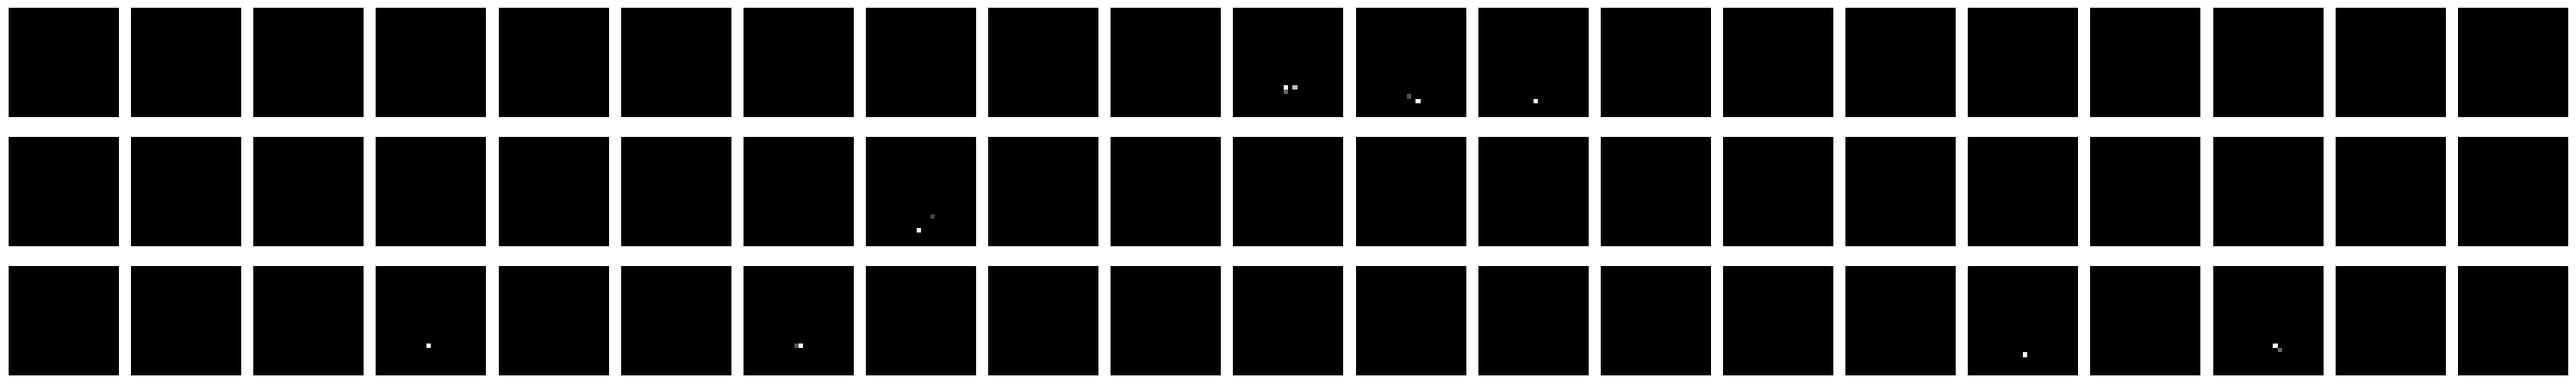

In [101]:
visualize_features(sample_features, 3)

Batch visualization

Filter out features that have no info across all images

In [102]:
def get_non_empty_feature_indices(images, network):
    all_sample_features = []
    for i in range(len(images)):
        sample_image = images[i]
        sample_batch = sample_image.unsqueeze(0).permute(0, 3, 1, 2) / 1.0
        with torch.no_grad():
            sample_features = network(sample_batch)
            all_sample_features.append(sample_features)
    all_sample_features_tensor = torch.cat(all_sample_features, dim=0)
    # Sum the features across images, if a feature is 0 for all images it will be 0 in the sum
    sum_features = torch.sum(all_sample_features_tensor, dim=0)
    sum_features.shape
    non_empty_feature_indices = []
    for i in range(len(sum_features)):
        if torch.all(sum_features[i] == 0):
            continue
        non_empty_feature_indices.append(i)
    return non_empty_feature_indices

In [103]:
non_empty_feature_indices = get_non_empty_feature_indices(sample_images, actor_cnn)

In [104]:
non_empty_feature_indices

[3,
 5,
 6,
 8,
 10,
 11,
 12,
 17,
 18,
 19,
 27,
 28,
 29,
 31,
 33,
 34,
 36,
 39,
 40,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 52,
 56,
 58,
 59,
 60,
 63]

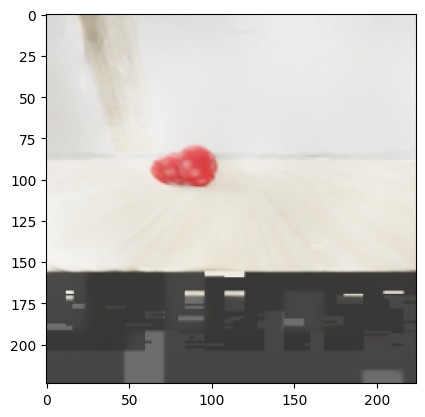

<Figure size 100x100 with 0 Axes>

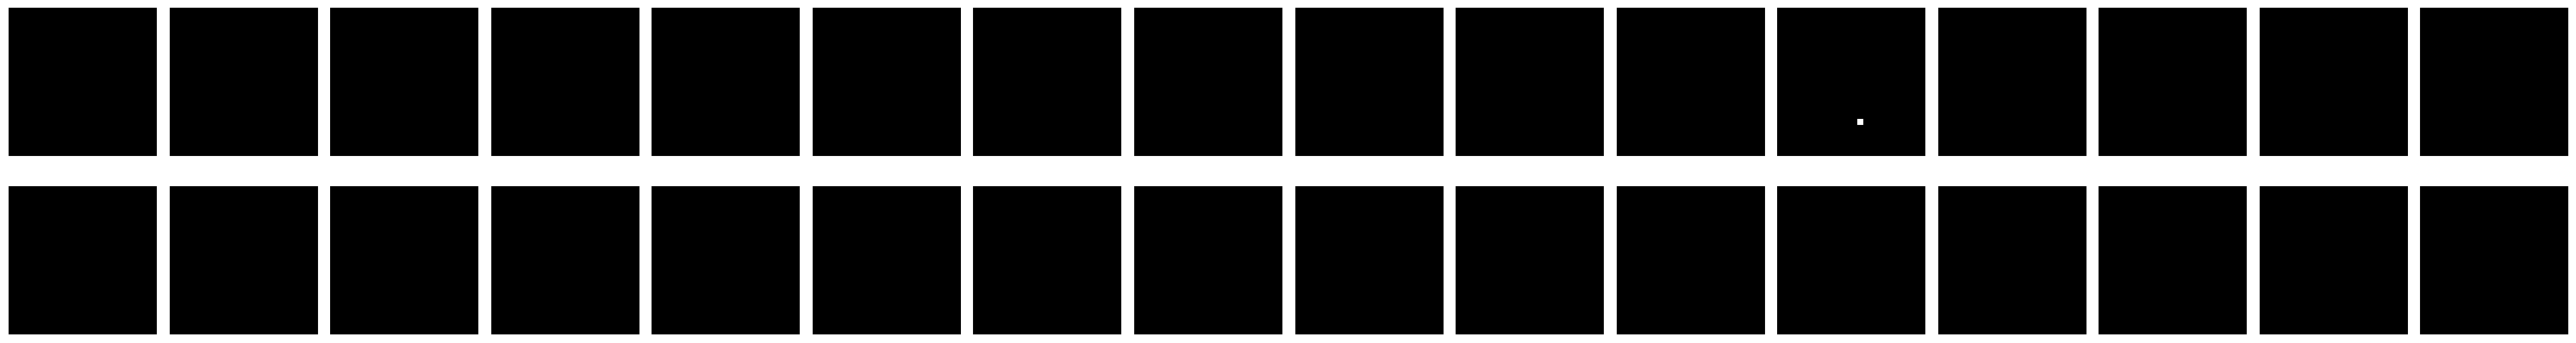

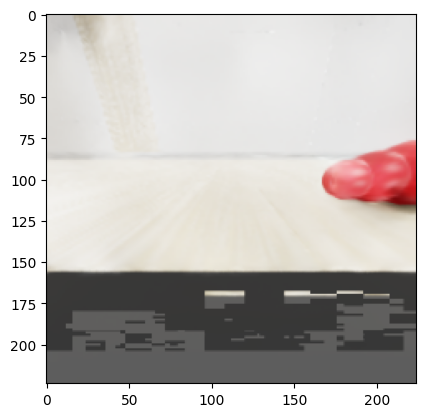

<Figure size 100x100 with 0 Axes>

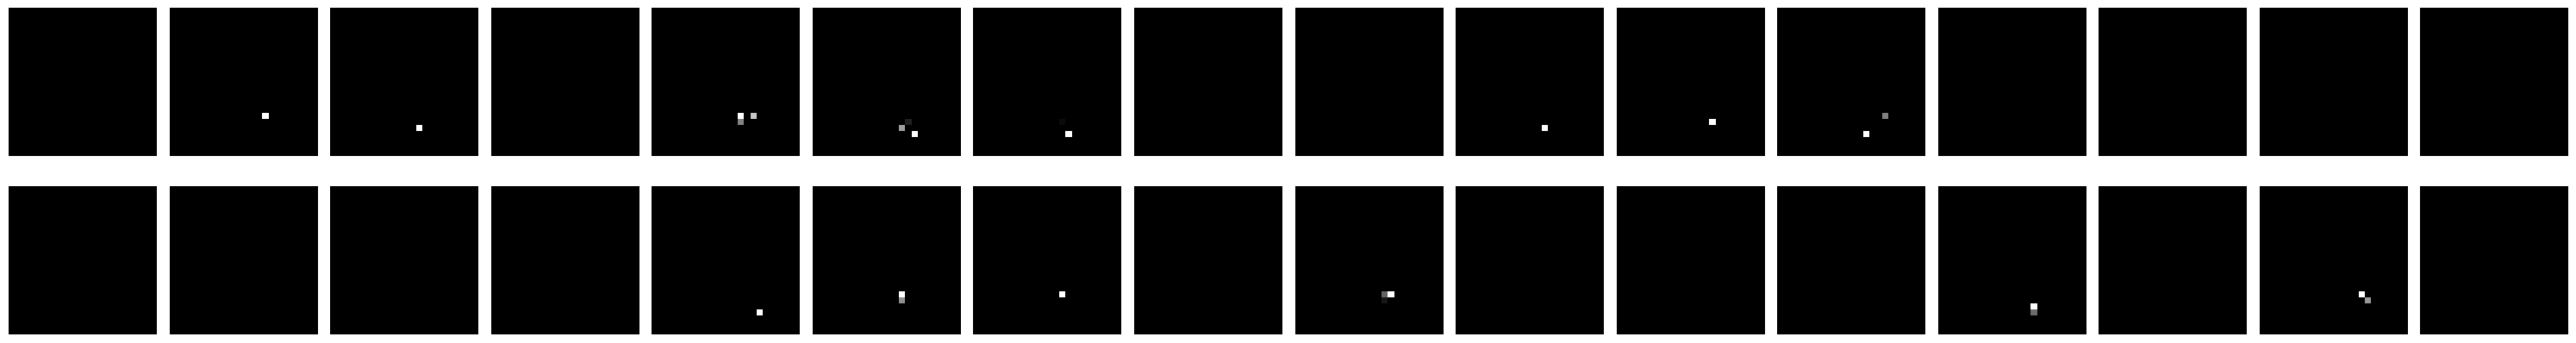

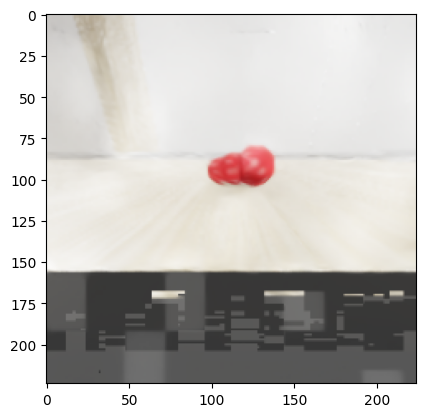

<Figure size 100x100 with 0 Axes>

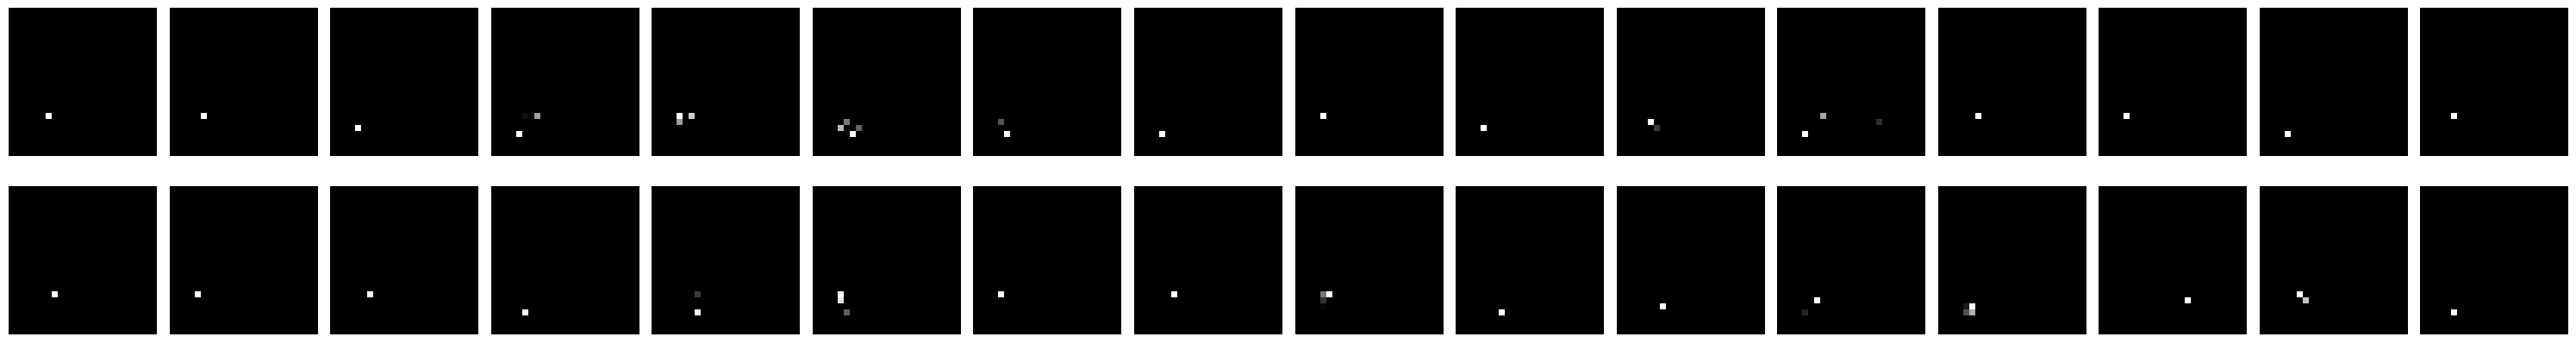

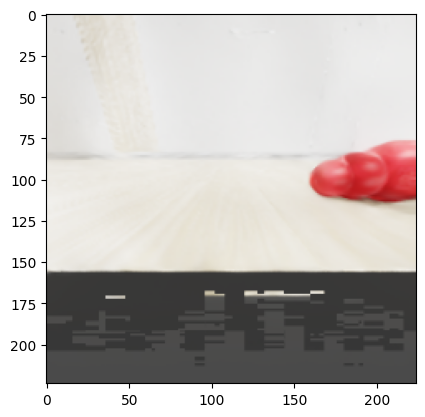

<Figure size 100x100 with 0 Axes>

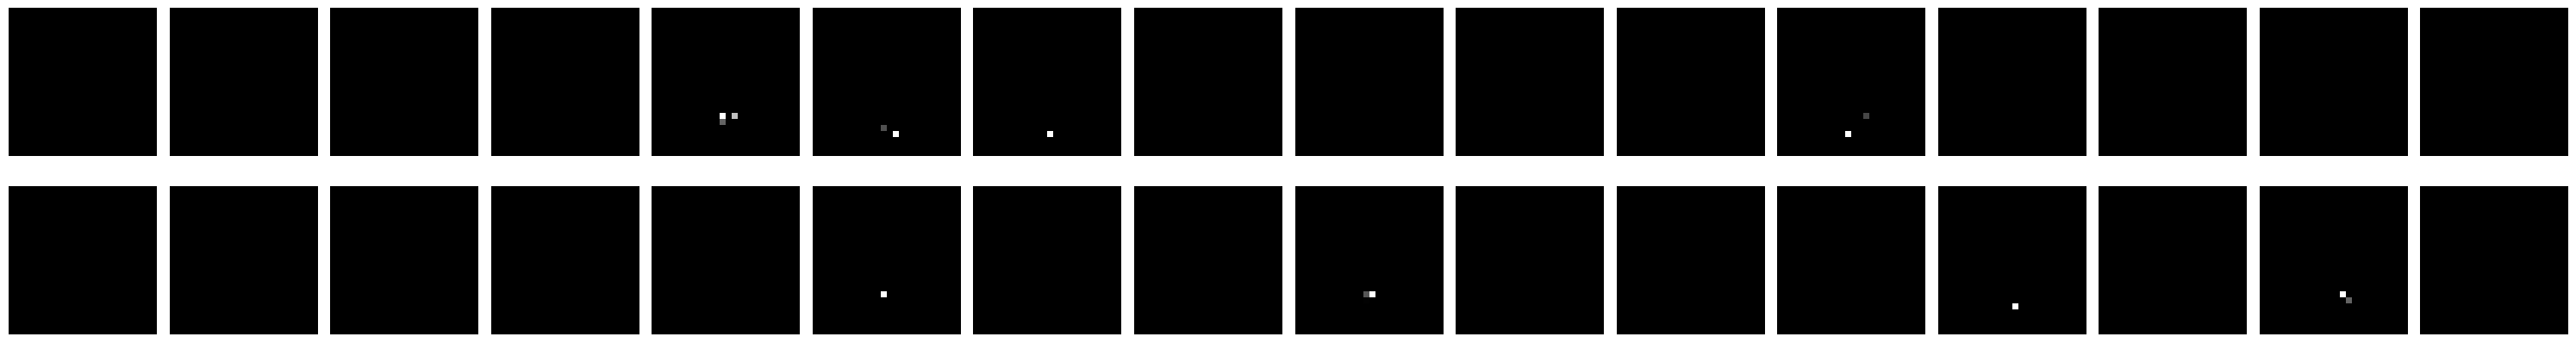

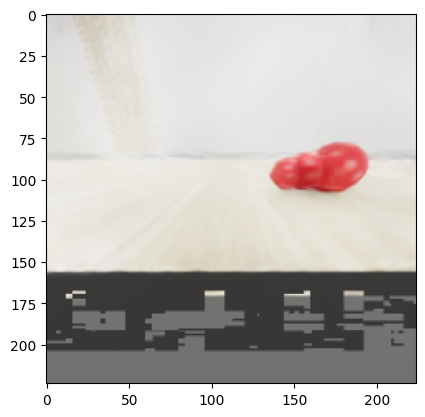

<Figure size 100x100 with 0 Axes>

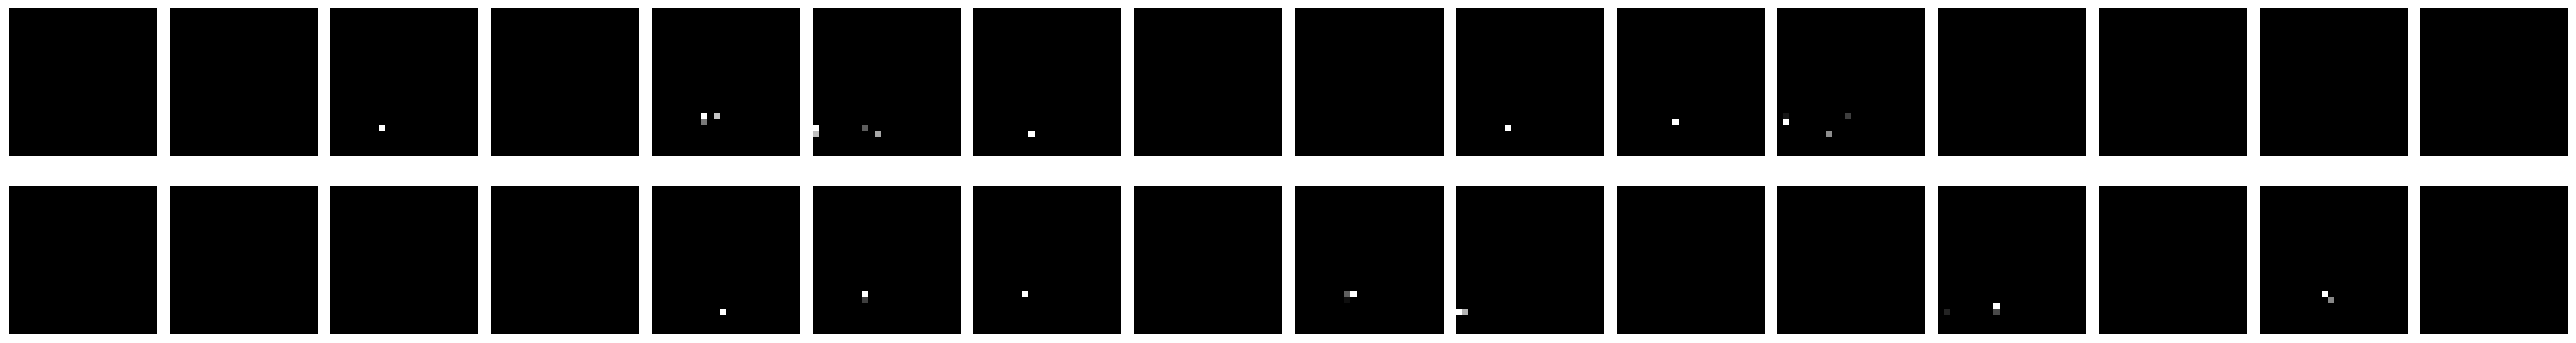

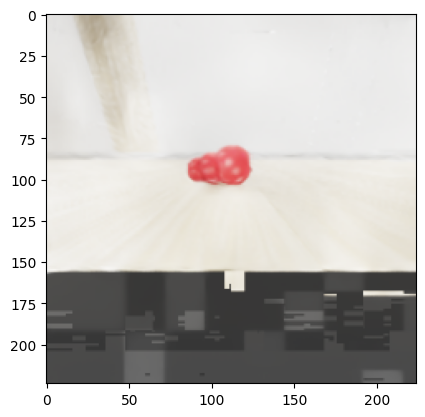

<Figure size 100x100 with 0 Axes>

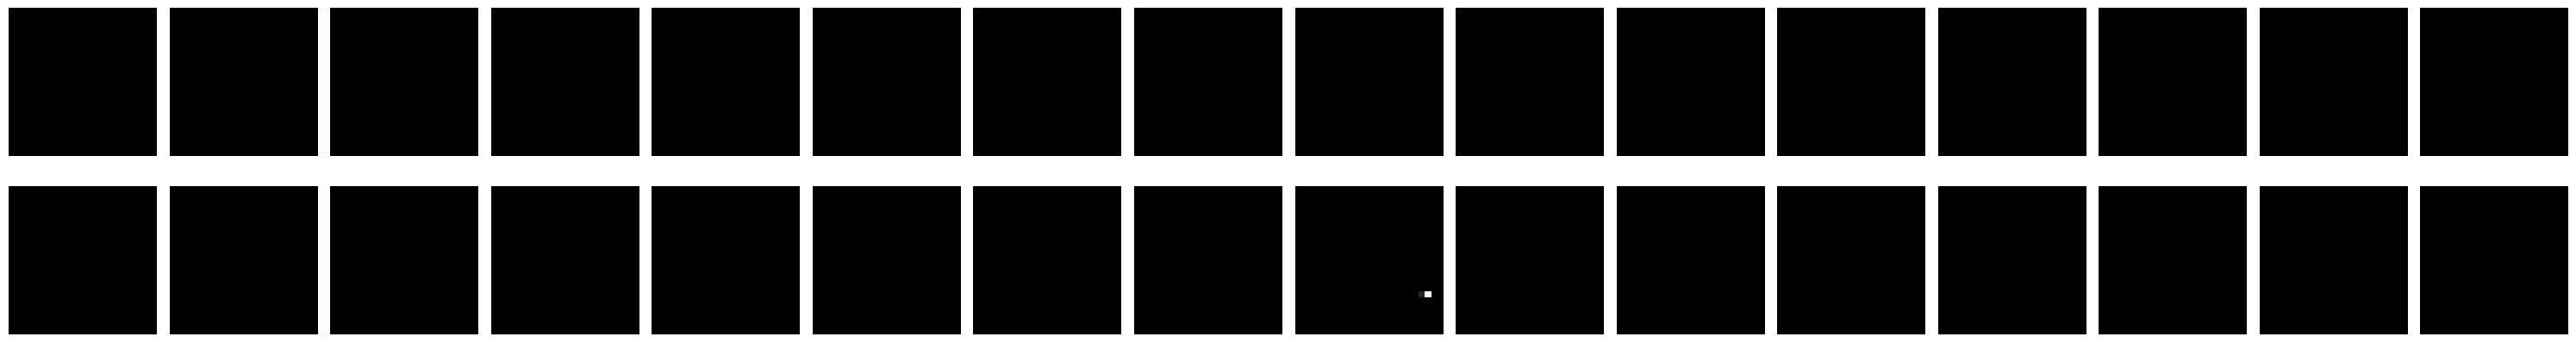

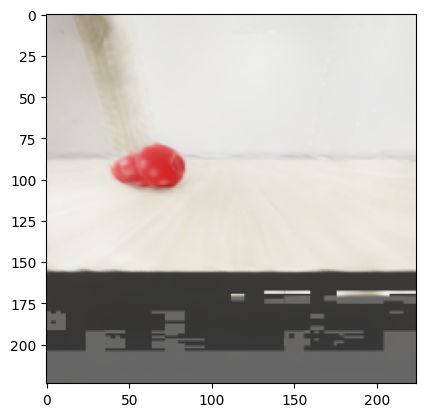

<Figure size 100x100 with 0 Axes>

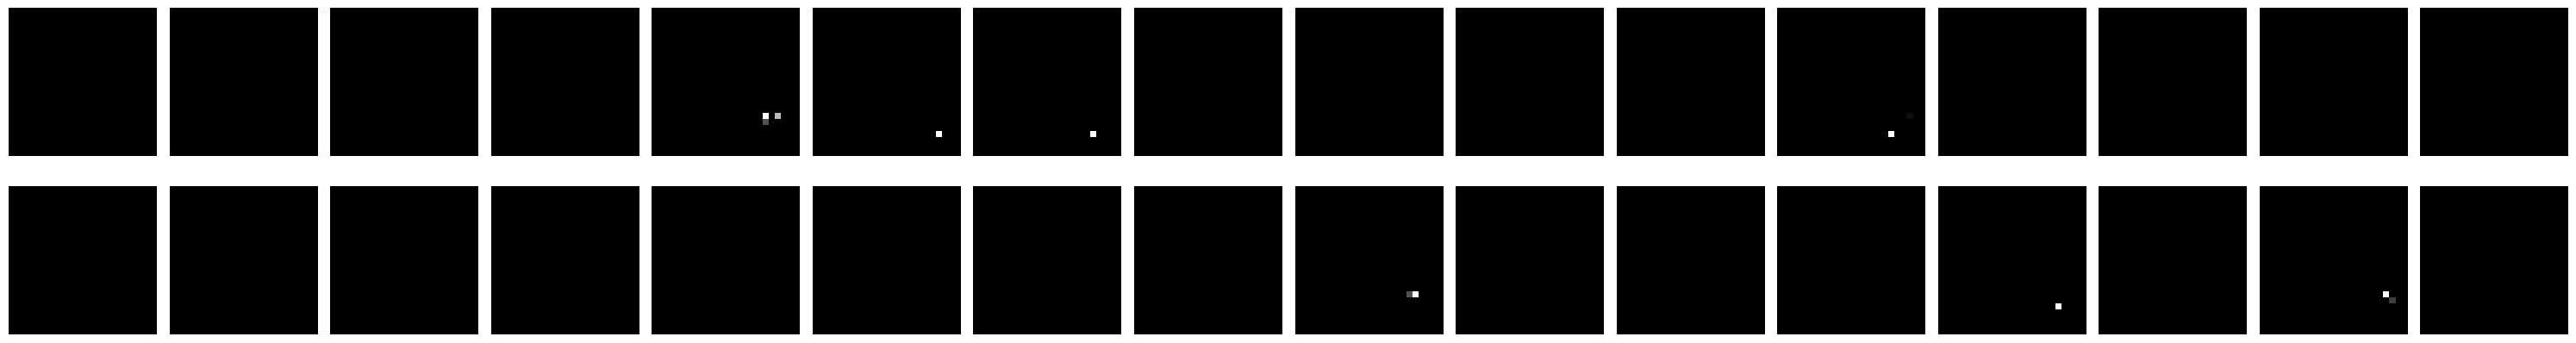

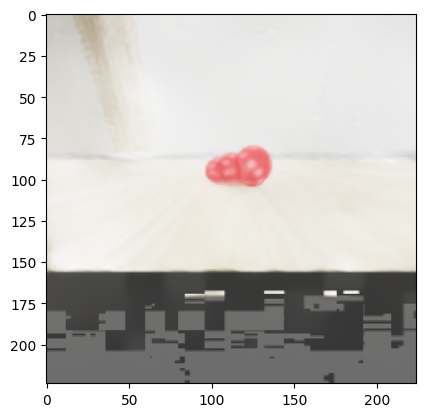

<Figure size 100x100 with 0 Axes>

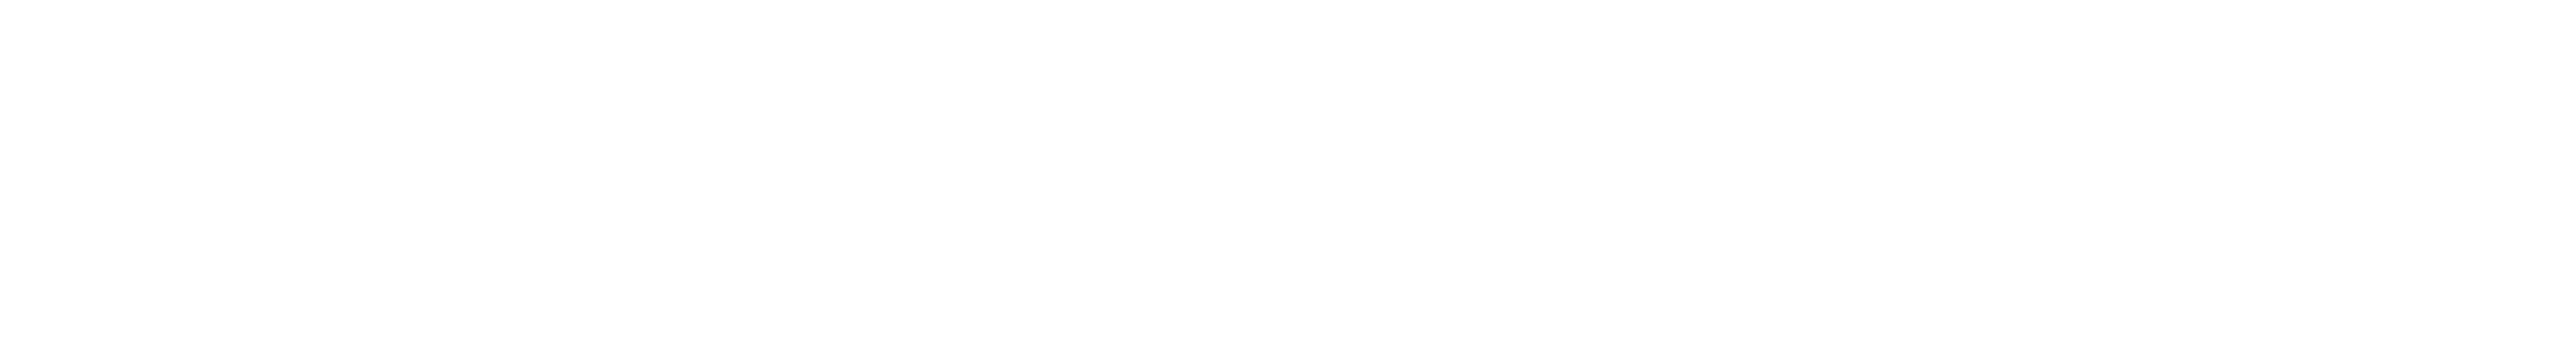

In [106]:
for idx in range(8):
    sample_image = sample_images[idx]
    
    plt.imshow(sample_image.cpu().numpy())
    plt.figure(figsize=(1,1))
    plt.show()
    sample_batch = sample_image.unsqueeze(0).permute(0, 3, 1, 2) / 1.0
    with torch.no_grad():
        sample_features = actor_cnn(sample_batch)
        non_empty_features = sample_features[0][torch.tensor(non_empty_feature_indices)]
        visualize_features(non_empty_features, 2)

Visualize Layer 1 Features

In [112]:
layer1 = torch.nn.Sequential(model.a2c_network.actor_cnn[0], model.a2c_network.actor_cnn[1])

In [113]:
sample_image.permute(2,0,1).shape

torch.Size([3, 224, 224])

In [115]:
layer1(sample_image.permute(2, 0, 1) / 1.0)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

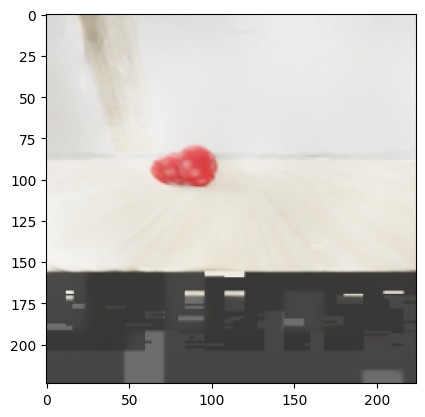

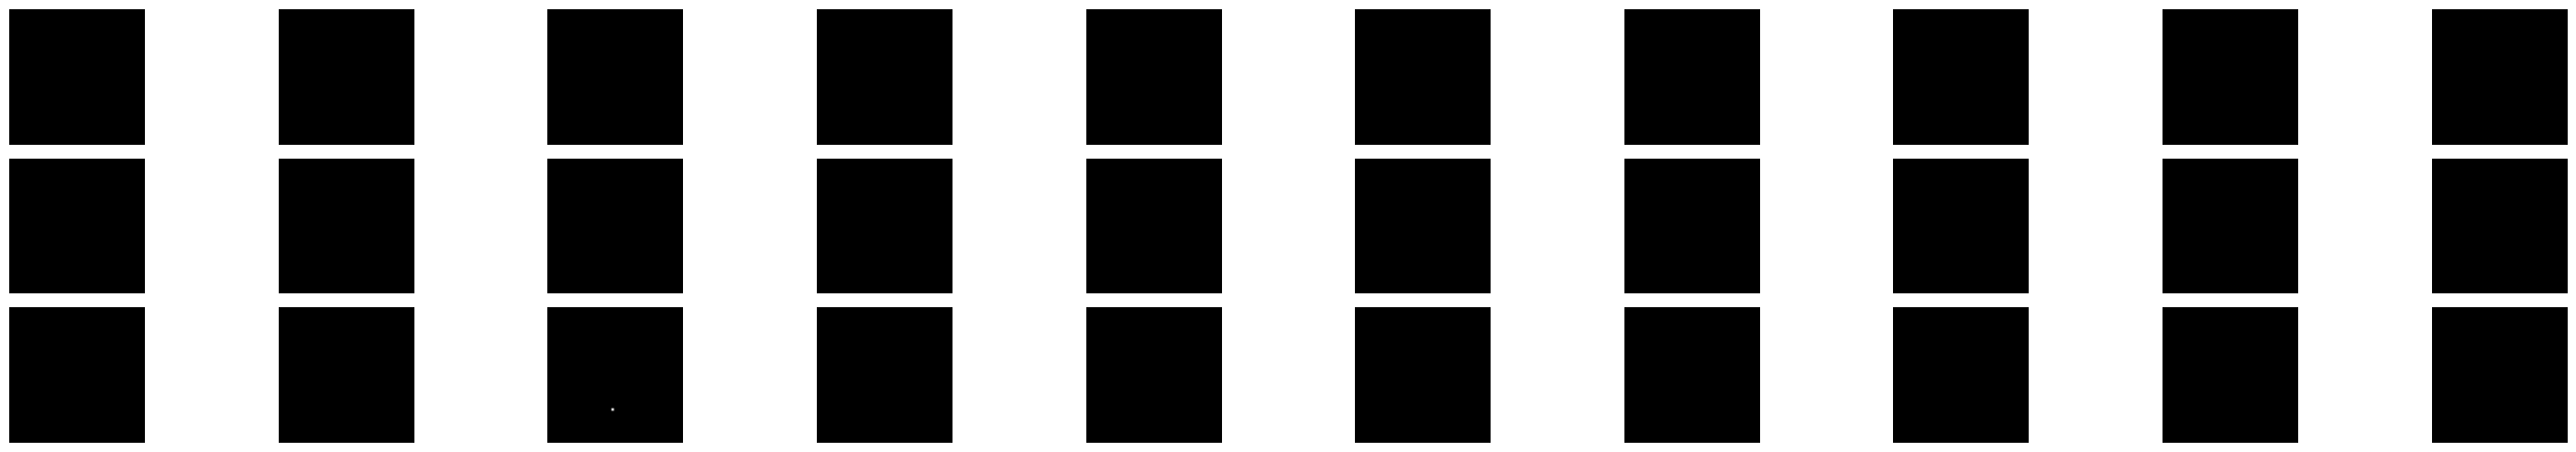

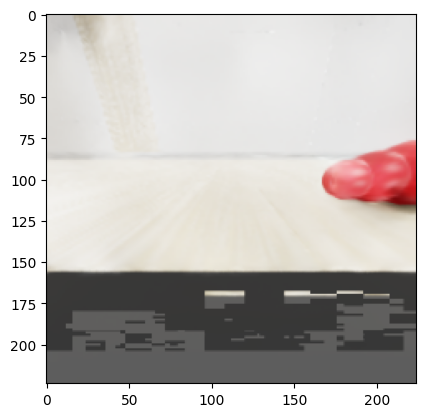

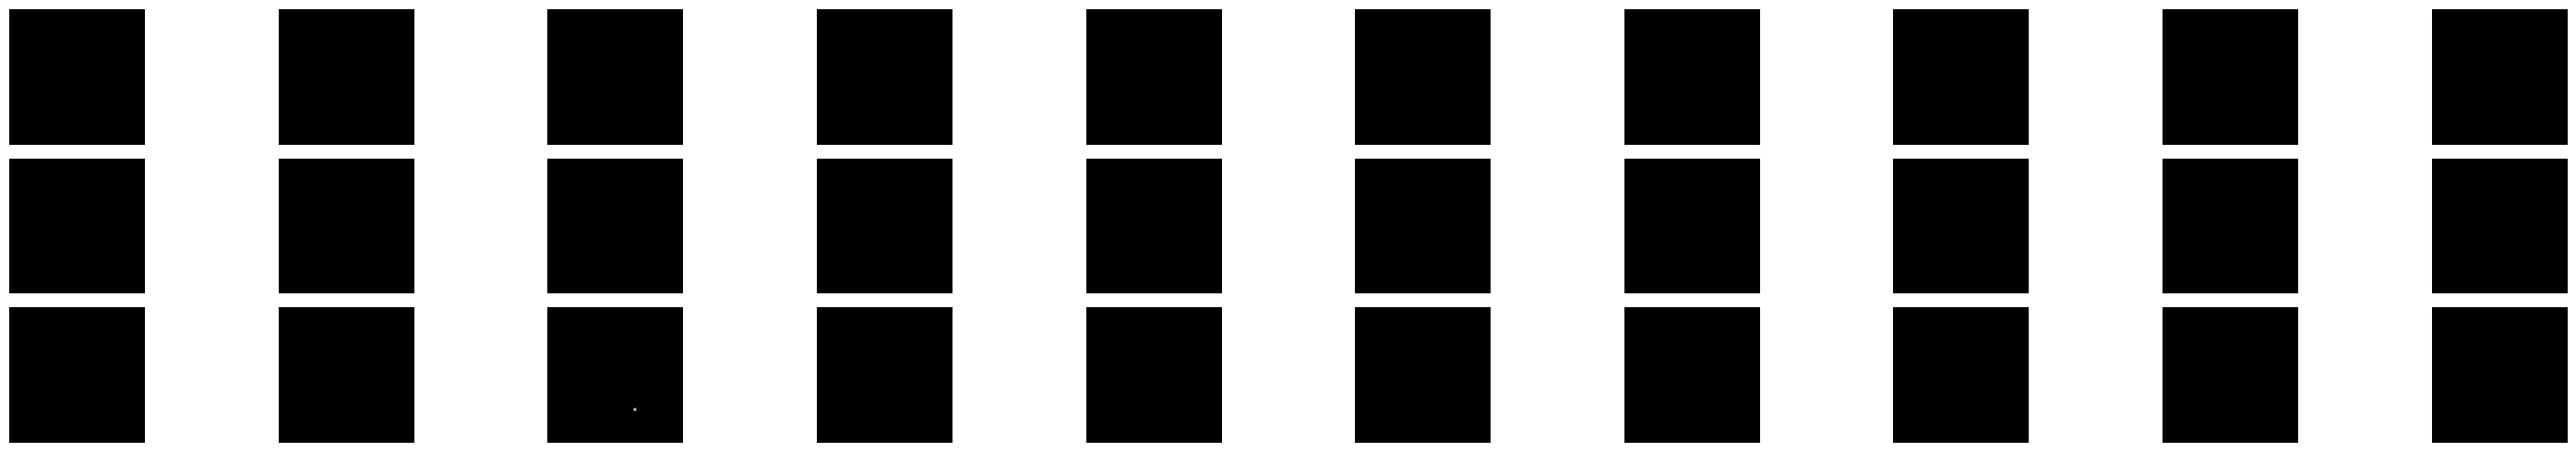

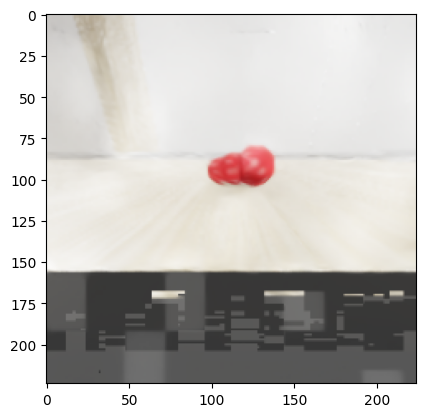

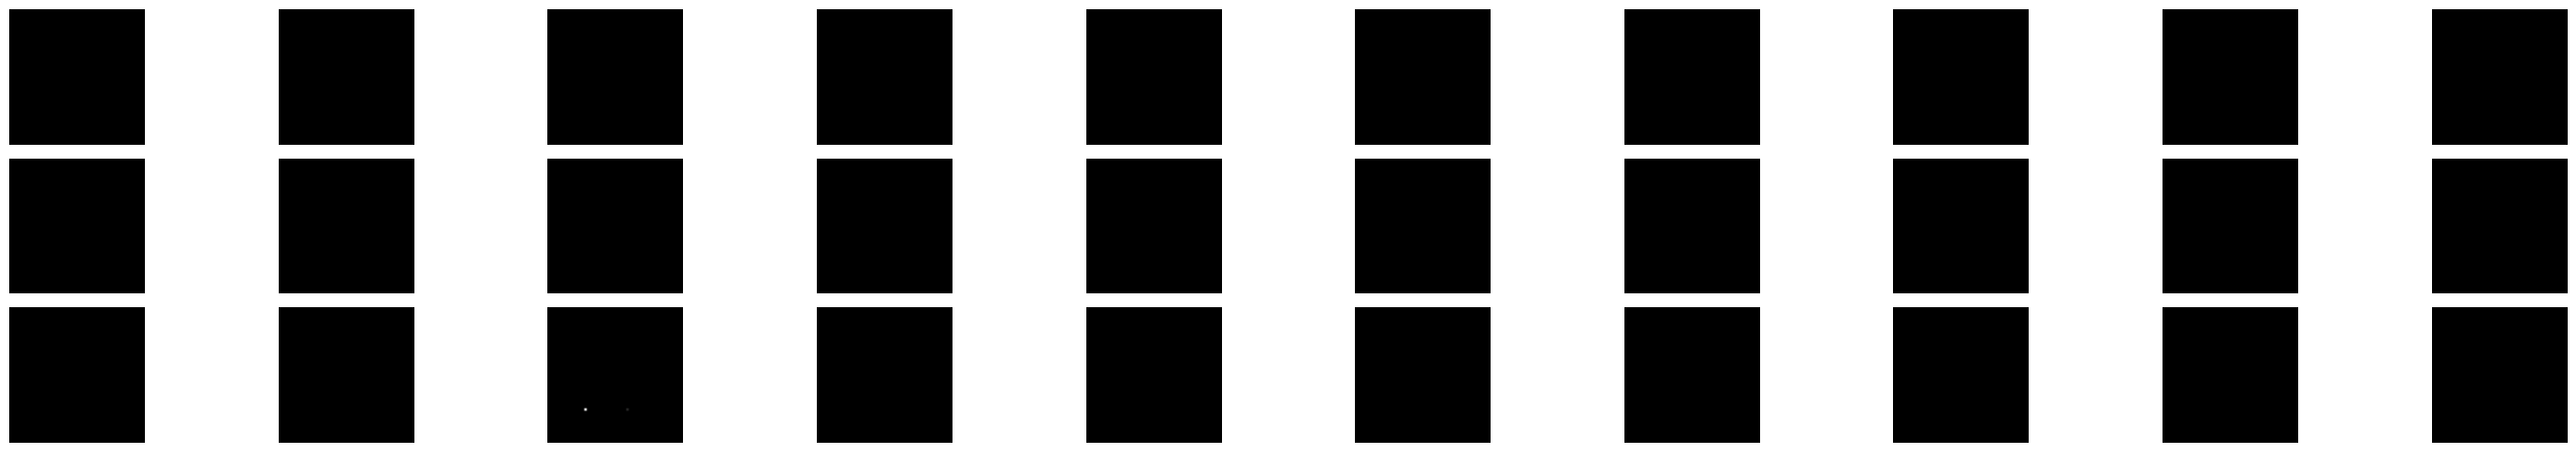

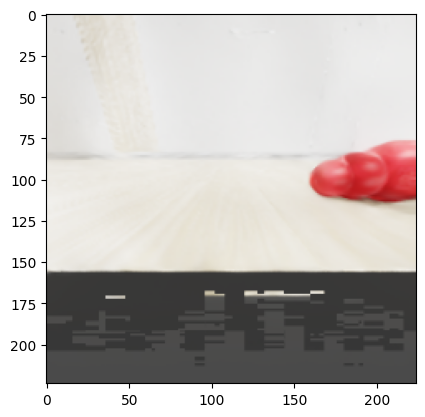

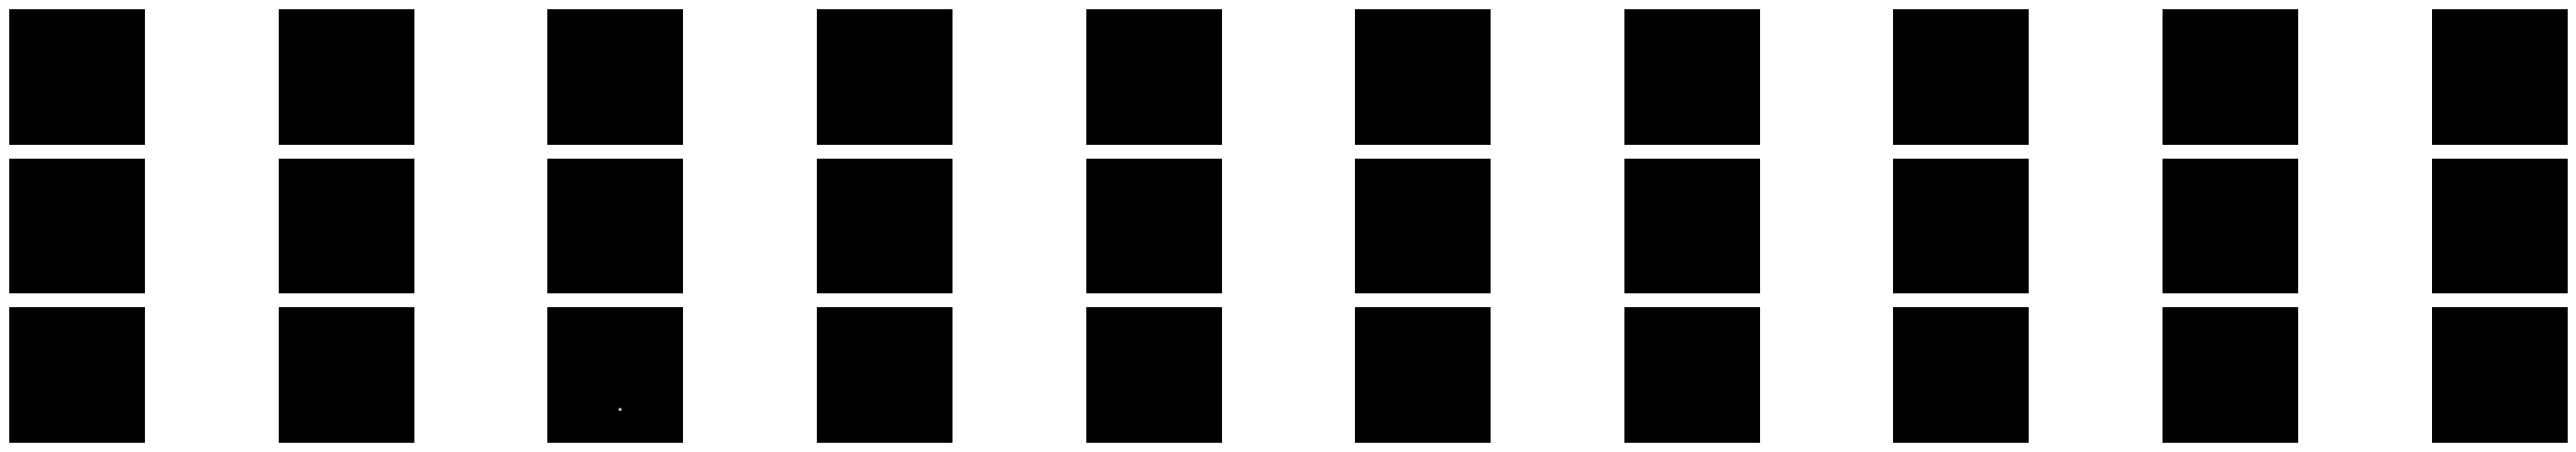

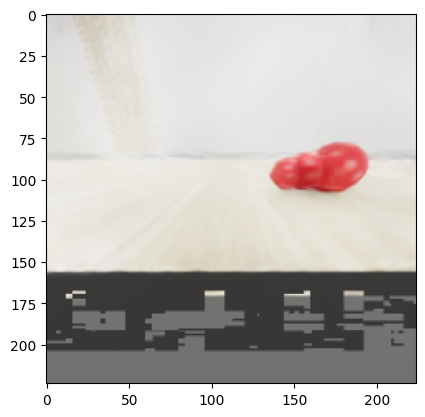

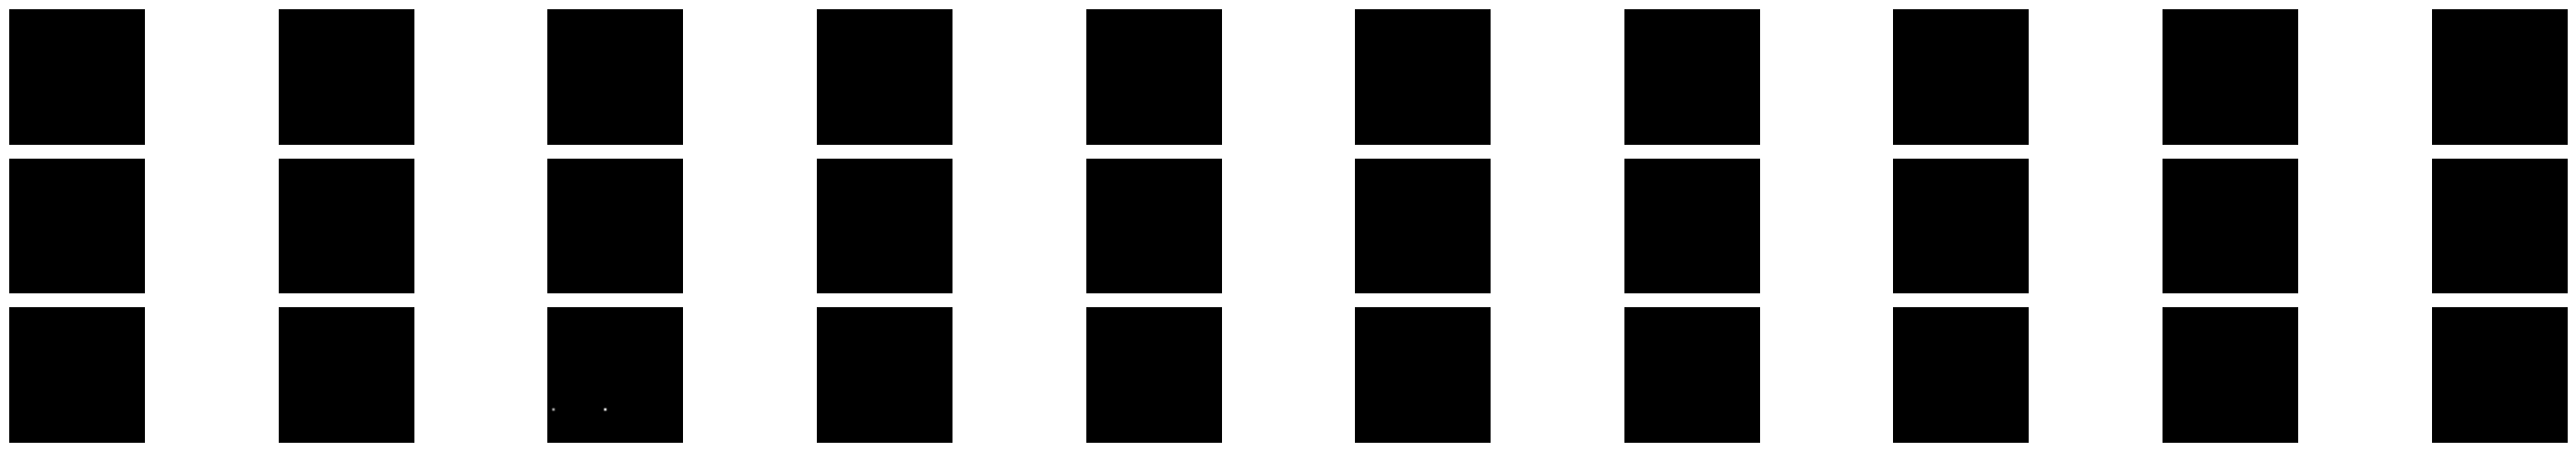

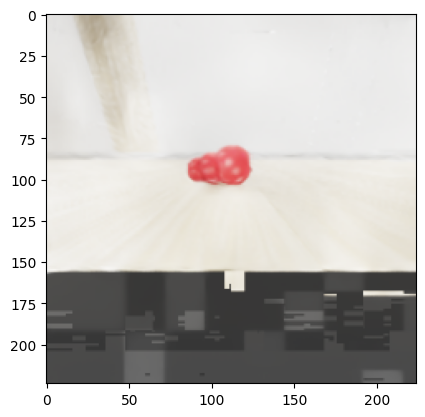

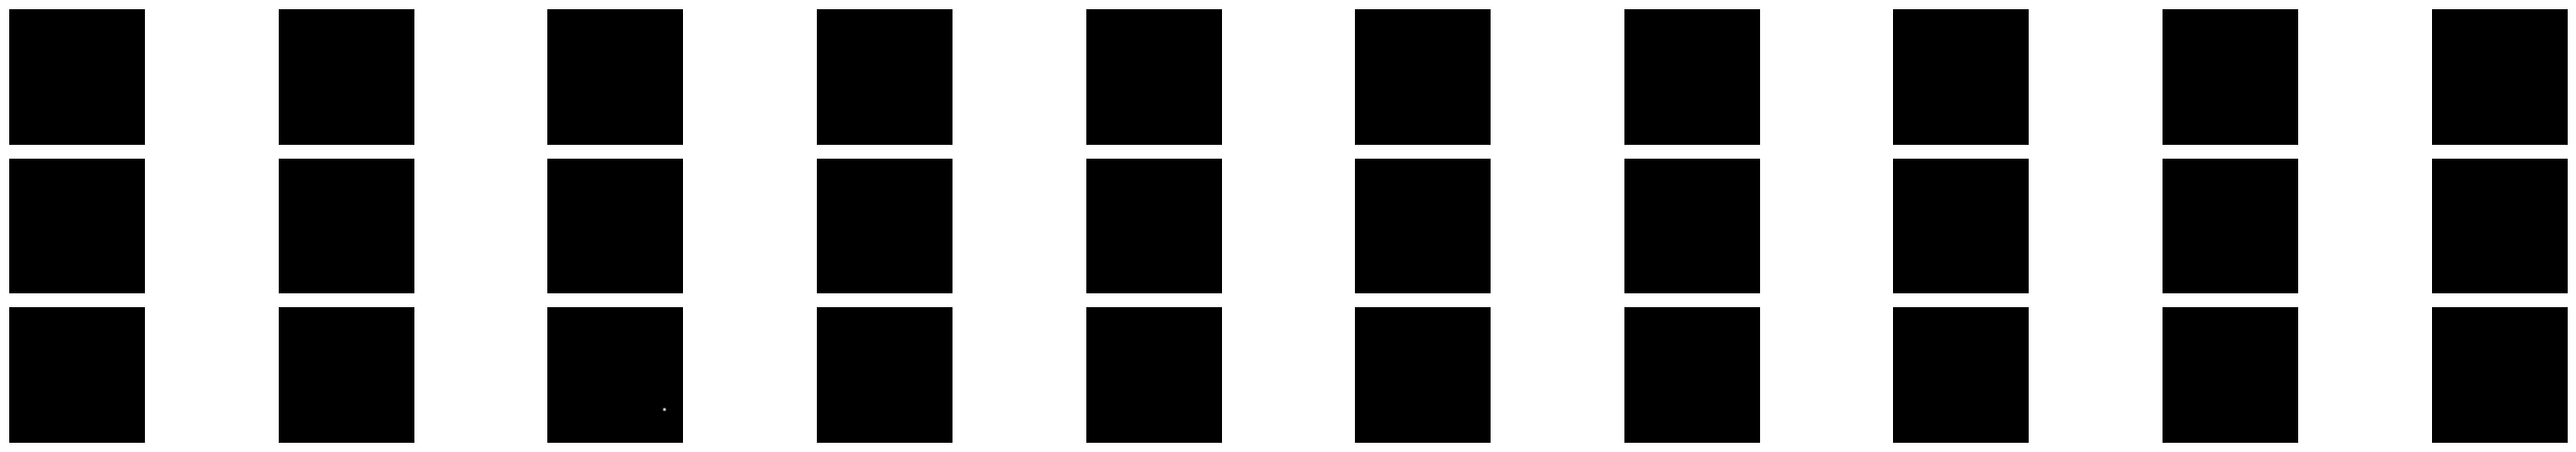

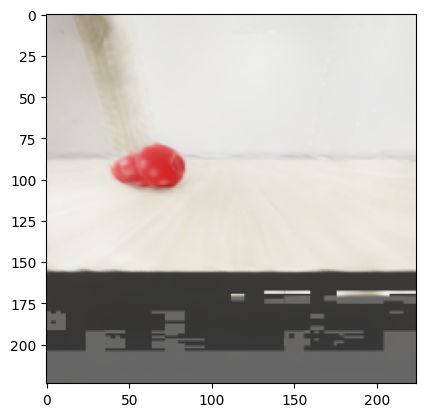

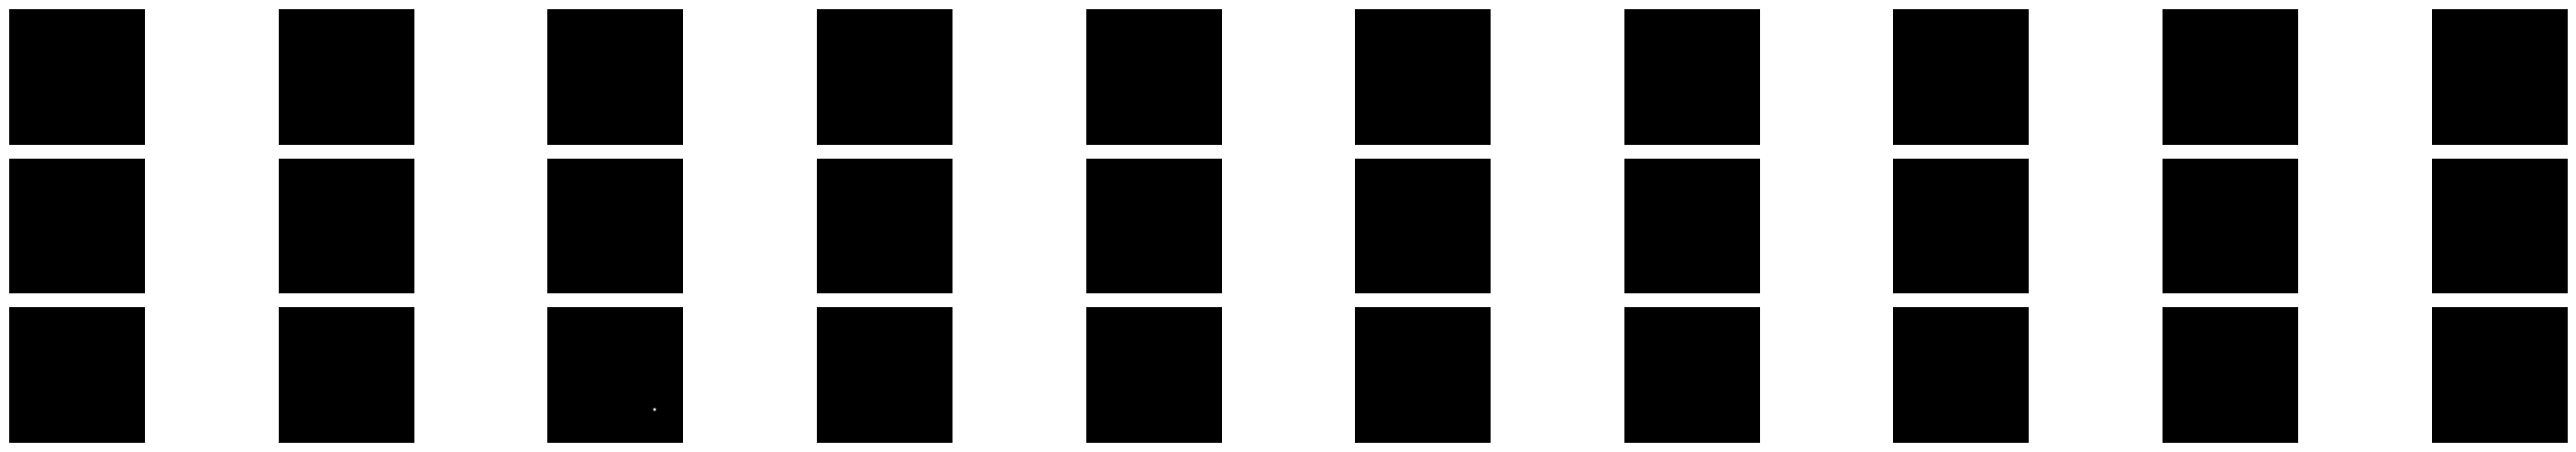

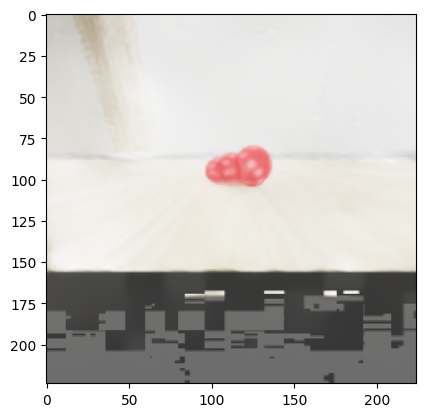

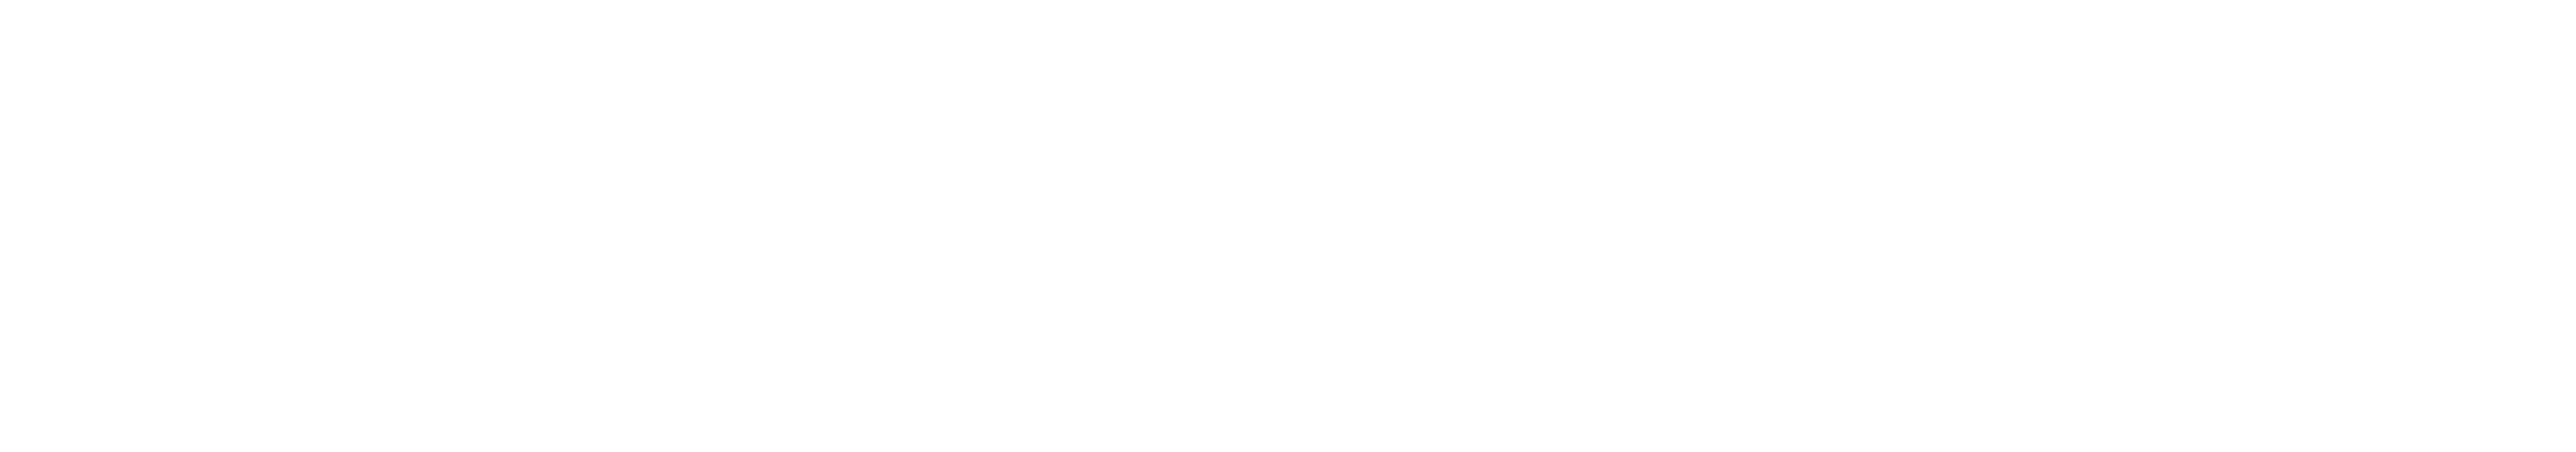

In [120]:
for idx in range(8):
    sample_image = sample_images[idx]
    
    plt.imshow(sample_image.cpu().numpy())
    plt.show()
    sample_batch = sample_image.unsqueeze(0).permute(0, 3, 1, 2) / 1.0
    with torch.no_grad():
        sample_features = layer1(sample_batch)
        non_empty_features = sample_features[0]
        visualize_features(non_empty_features, 3)

Visualize Layer 2

In [117]:
layer2 = torch.nn.Sequential(model.a2c_network.actor_cnn[0], model.a2c_network.actor_cnn[1], model.a2c_network.actor_cnn[2], model.a2c_network.actor_cnn[3])

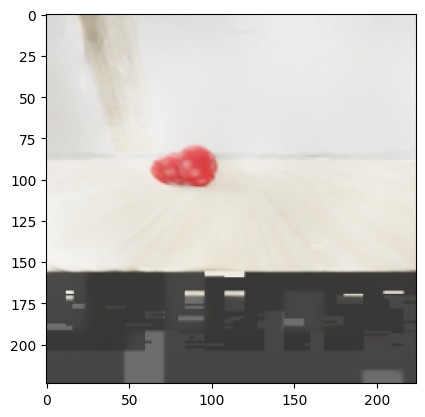

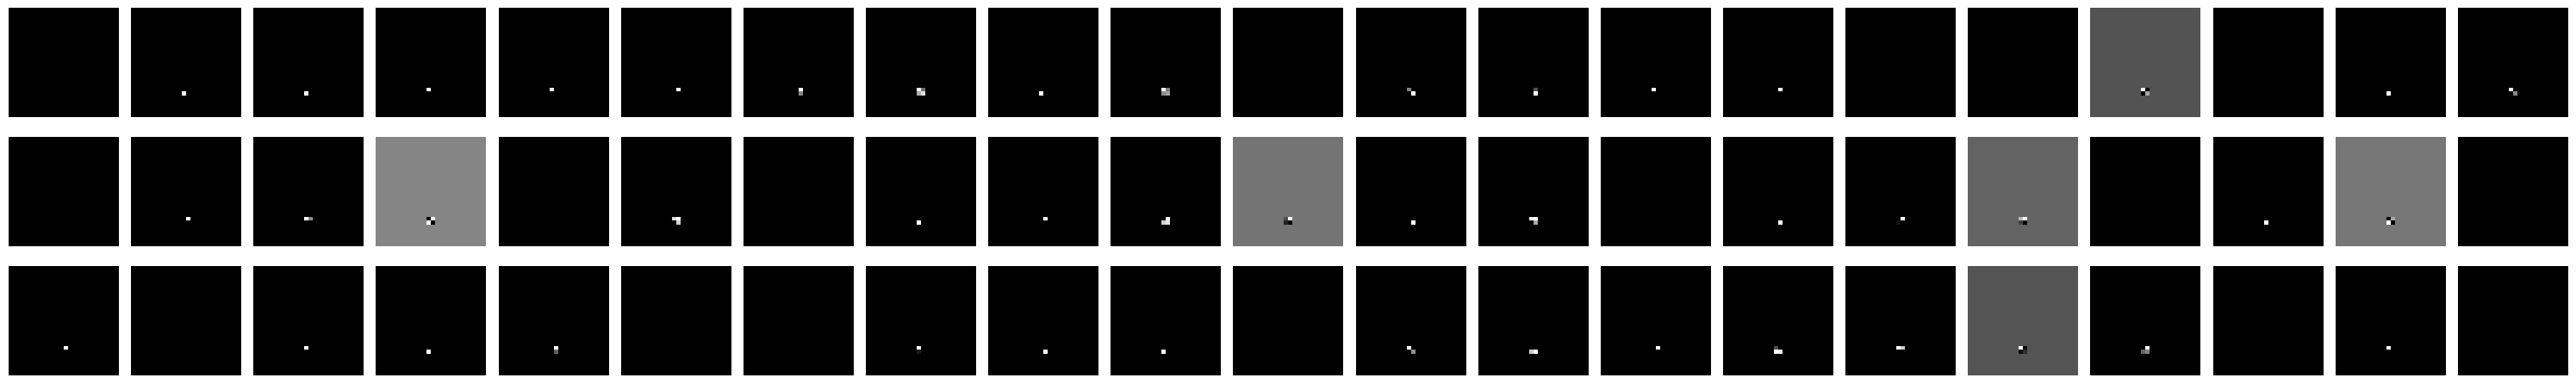

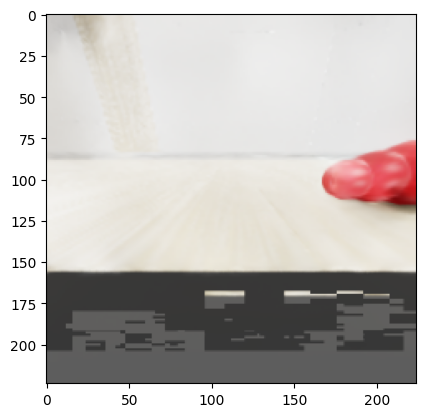

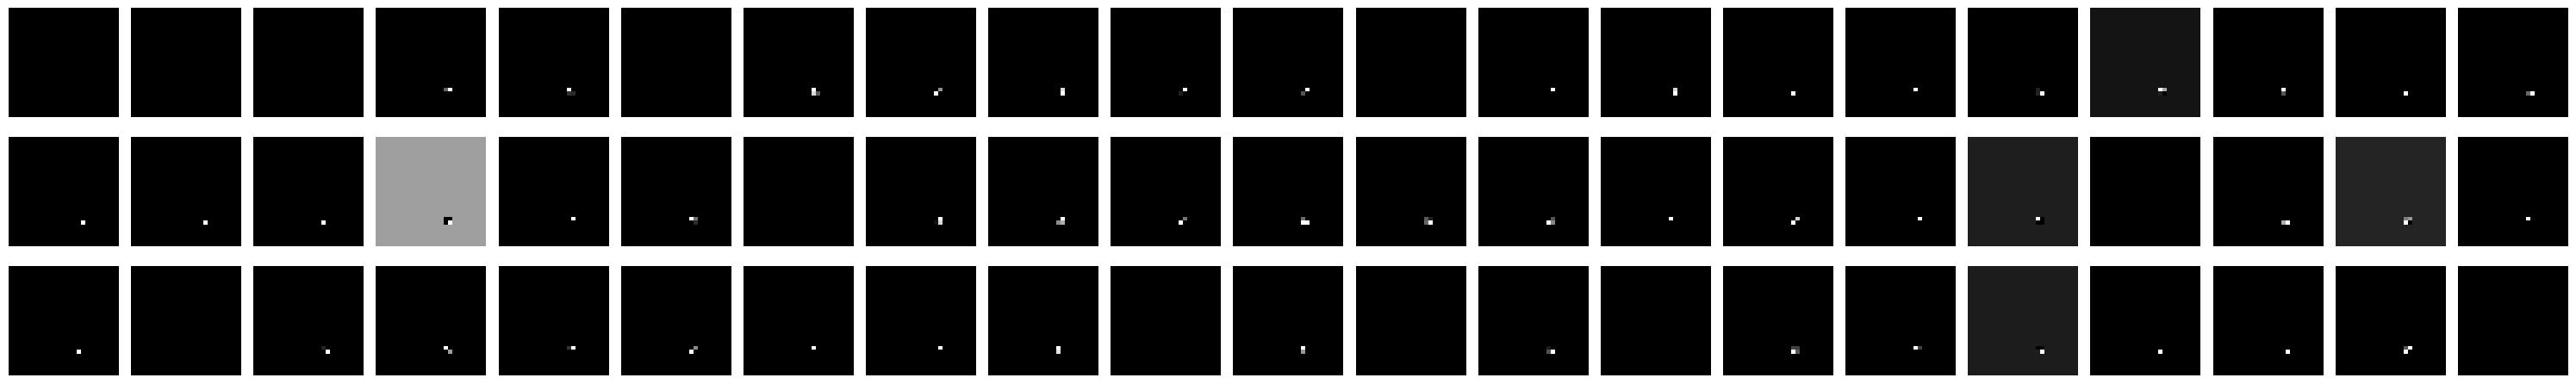

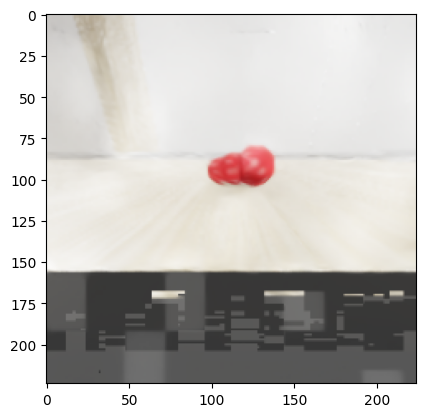

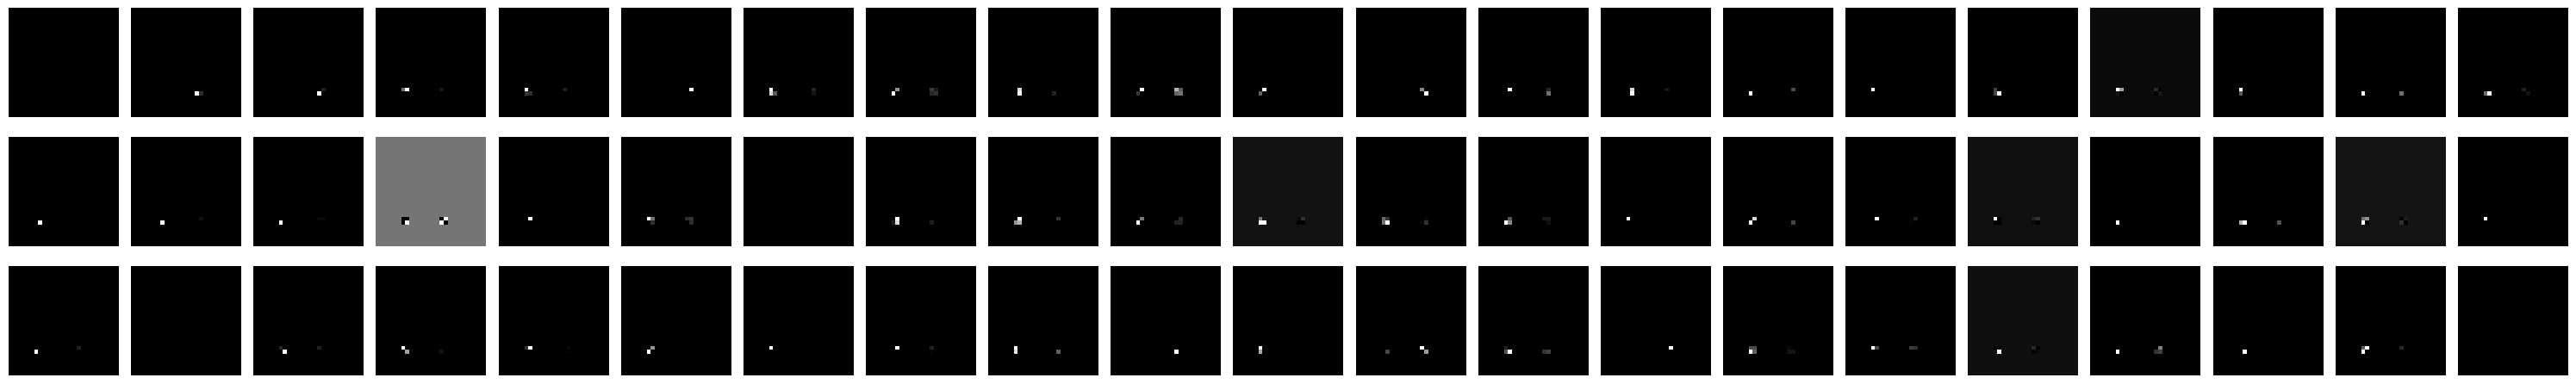

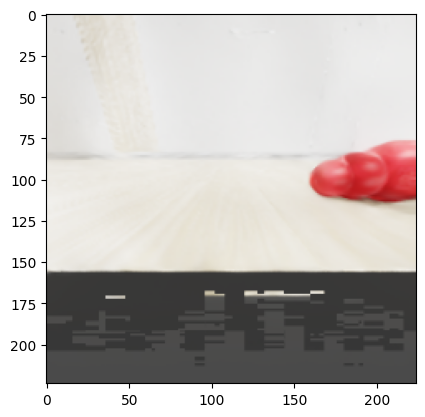

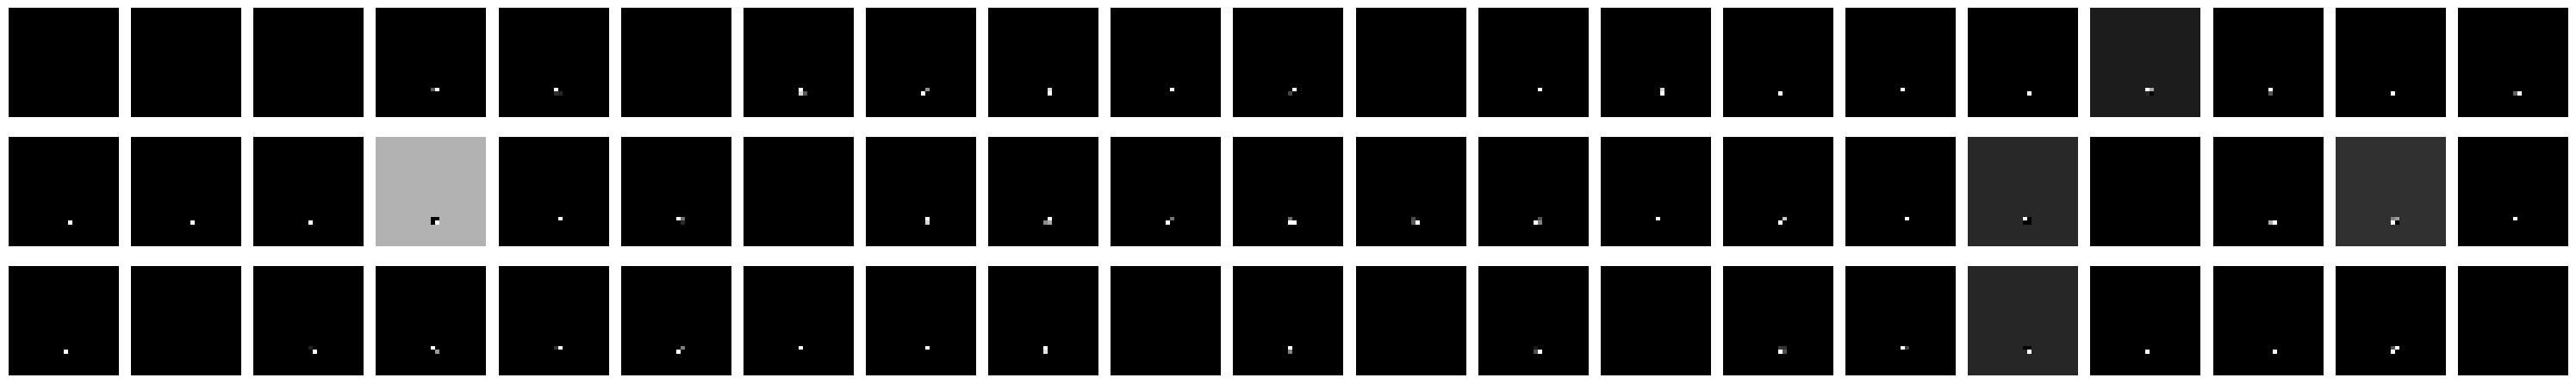

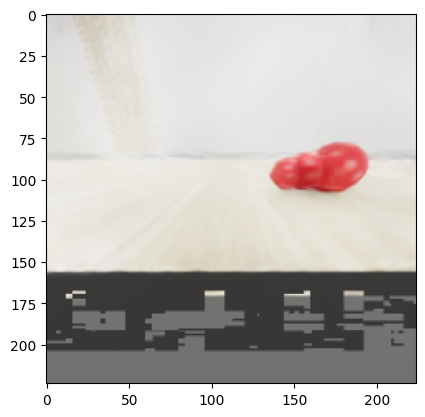

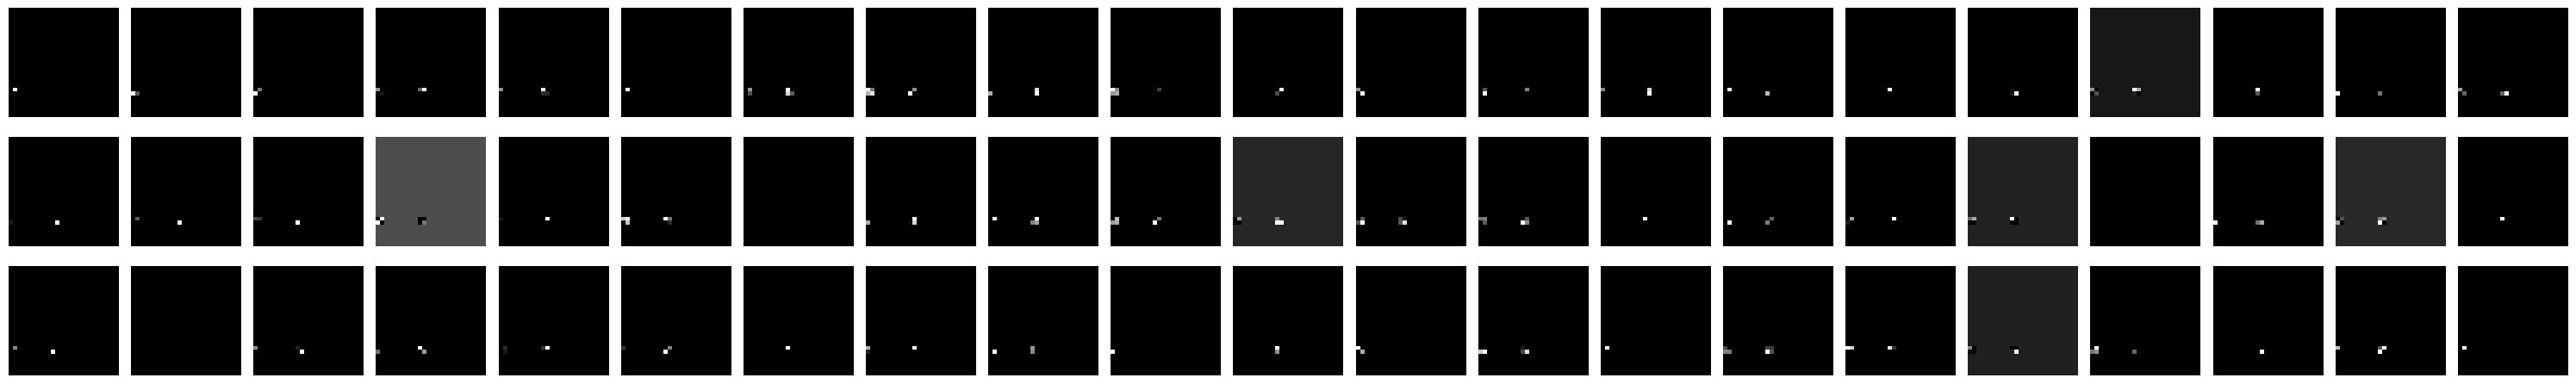

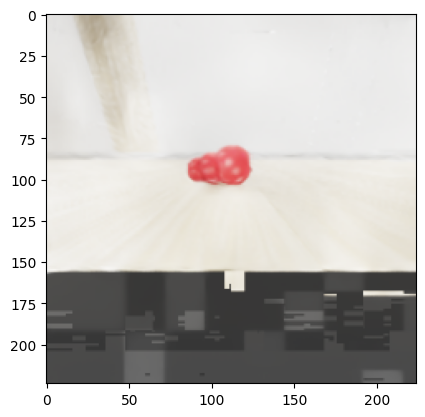

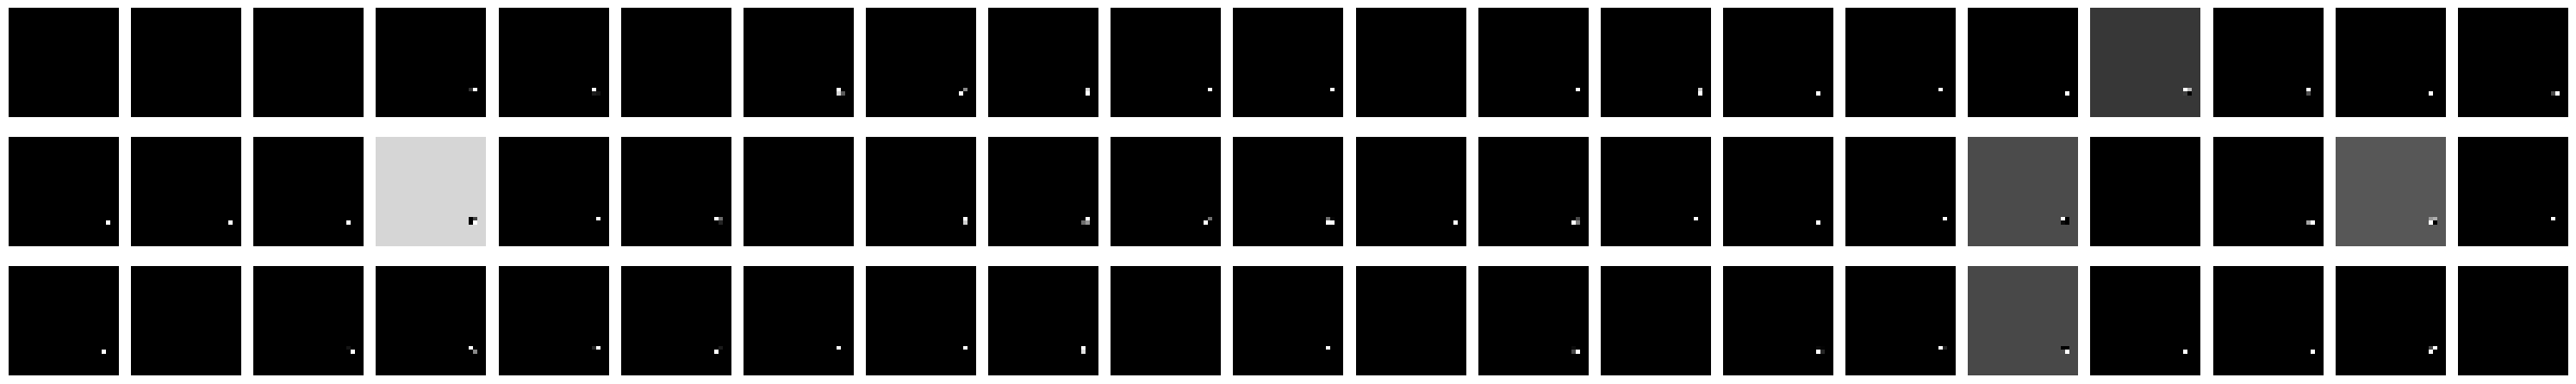

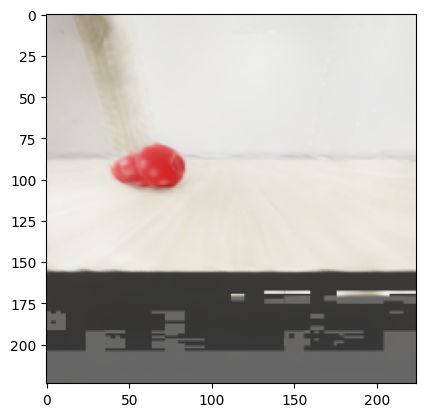

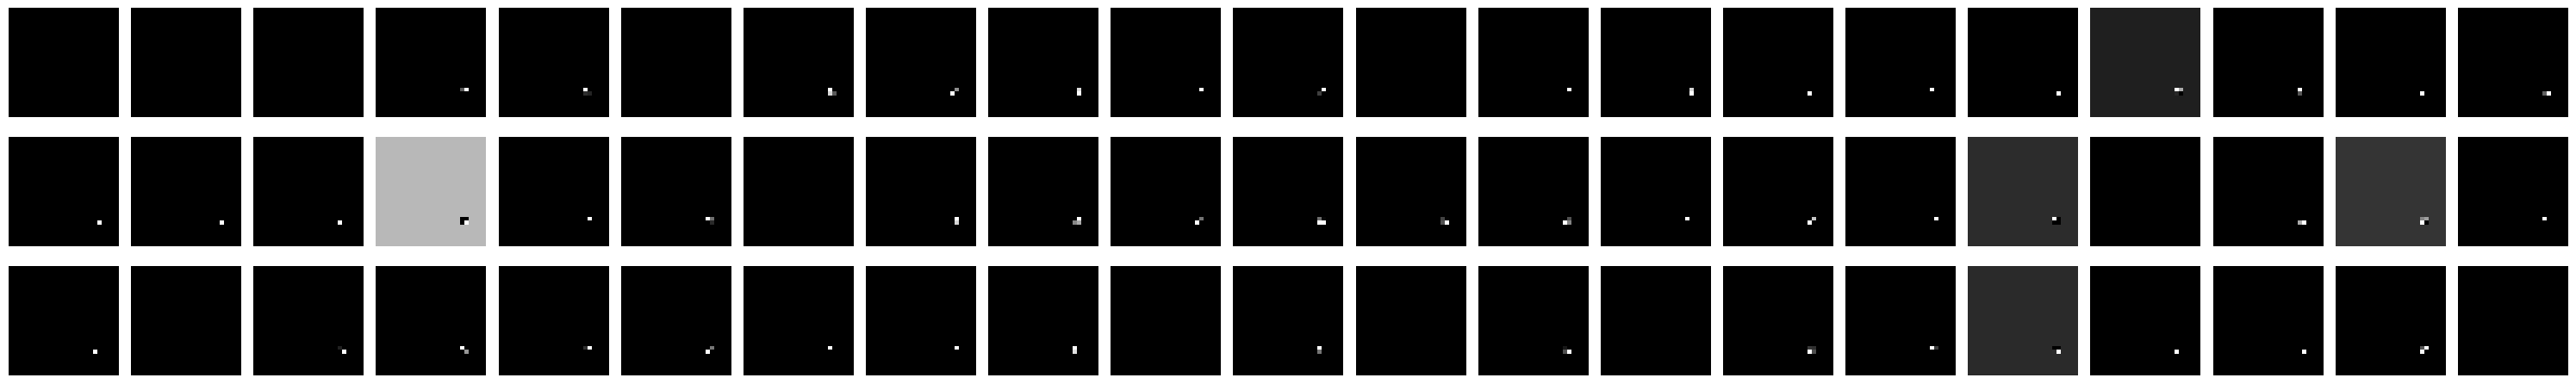

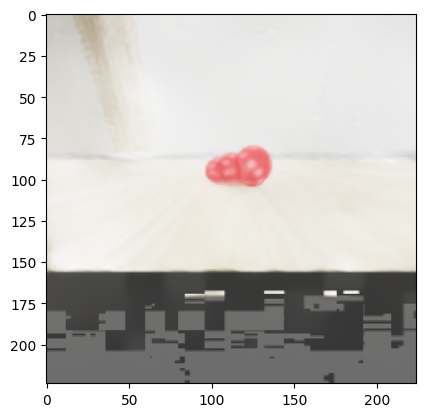

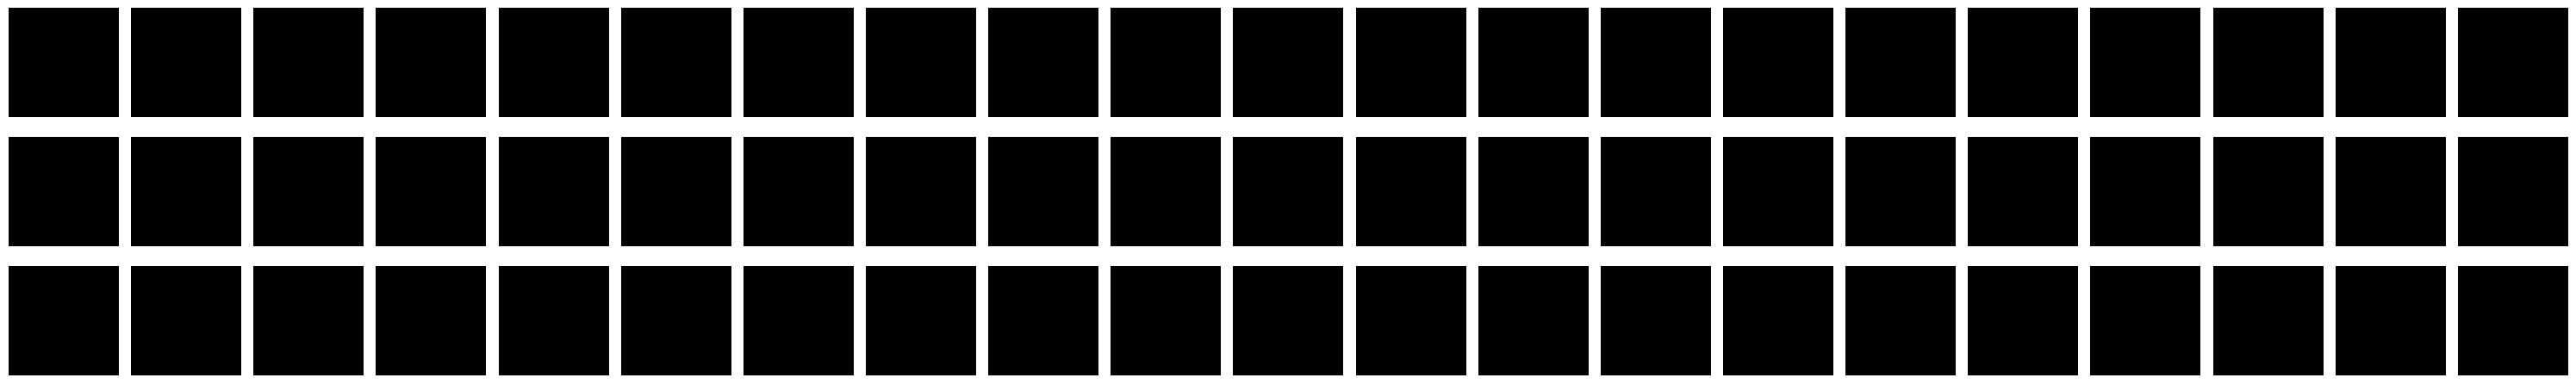

In [119]:
for idx in range(8):
    sample_image = sample_images[idx]
    
    plt.imshow(sample_image.cpu().numpy())
    plt.show()
    sample_batch = sample_image.unsqueeze(0).permute(0, 3, 1, 2) / 1.0
    with torch.no_grad():
        sample_features = layer2(sample_batch)
        non_empty_features = sample_features[0]
        visualize_features(non_empty_features, 3)